In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Chemin du dataset
dataset_path = r"C:\\Users\\BilalBENELKADI\\OneDrive - ALFUN\\Documents\\CESI\\DATASCIENCE\\dataset"

# Augmentation des données pour l'ensemble d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Pas d'augmentation pour l'ensemble de validation
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Générateurs
photos_gen = train_datagen.flow_from_directory(directory=dataset_path, target_size=(224, 224), classes=["Photo"], class_mode="binary", subset="training", batch_size=32)
others_gen = train_datagen.flow_from_directory(directory=dataset_path, target_size=(224, 224), classes=["Text", "Sketch", "Schematics", "Painting"], class_mode="binary", subset="training", batch_size=32)

photos_val_gen = val_datagen.flow_from_directory(directory=dataset_path, target_size=(224, 224), classes=["Photo"], class_mode="binary", subset="validation", batch_size=32)
others_val_gen = val_datagen.flow_from_directory(directory=dataset_path, target_size=(224, 224), classes=["Text", "Sketch", "Schematics", "Painting"], class_mode="binary", subset="validation", batch_size=32)

# Fusion des générateurs
def custom_merge_gen(photo_gen, other_gen):
    while True:
        photo_data, _ = photo_gen.next()
        other_data, _ = other_gen.next()

        # Création des labels
        photo_labels = np.ones(photo_data.shape[0])
        other_labels = np.zeros(other_data.shape[0])

        # Fusion des données et des labels
        combined_data = np.vstack((photo_data, other_data))
        combined_labels = np.hstack((photo_labels, other_labels))

        yield combined_data, combined_labels

train_generator = custom_merge_gen(photos_gen, others_gen)
val_generator = custom_merge_gen(photos_val_gen, others_val_gen)

# Modèle
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilation avec un taux d'apprentissage réduit
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callback pour l'arrêt précoce
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement
history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stopping], steps_per_epoch=len(photos_gen) + len(others_gen)//2, validation_steps=len(photos_val_gen) + len(others_val_gen)//2)



Found 7995 images belonging to 1 classes.
Found 25125 images belonging to 4 classes.
Found 1998 images belonging to 1 classes.
Found 6281 images belonging to 4 classes.
Epoch 1/10
643/643 [==============================] - 1757s 3s/step - loss: 0.5209 - accuracy: 0.7481 - val_loss: 0.5976 - val_accuracy: 0.6760
Epoch 2/10
643/643 [==============================] - 1838s 3s/step - loss: 0.4229 - accuracy: 0.8044 - val_loss: 0.5135 - val_accuracy: 0.7321
Epoch 3/10
643/643 [==============================] - 1902s 3s/step - loss: 0.3978 - accuracy: 0.8197 - val_loss: 0.4804 - val_accuracy: 0.7264
Epoch 4/10
643/643 [==============================] - 1812s 3s/step - loss: 0.3899 - accuracy: 0.8208 - val_loss: 0.4706 - val_accuracy: 0.7527
Epoch 5/10
643/643 [==============================] - 2123s 3s/step - loss: 0.3786 - accuracy: 0.8265 - val_loss: 0.4388 - val_accuracy: 0.7973
Epoch 6/10
643/643 [==============================] - 2799s 4s/step - loss: 0.3705 - accuracy: 0.8295 - val_los

In [1]:
model.summary

NameError: name 'model' is not defined

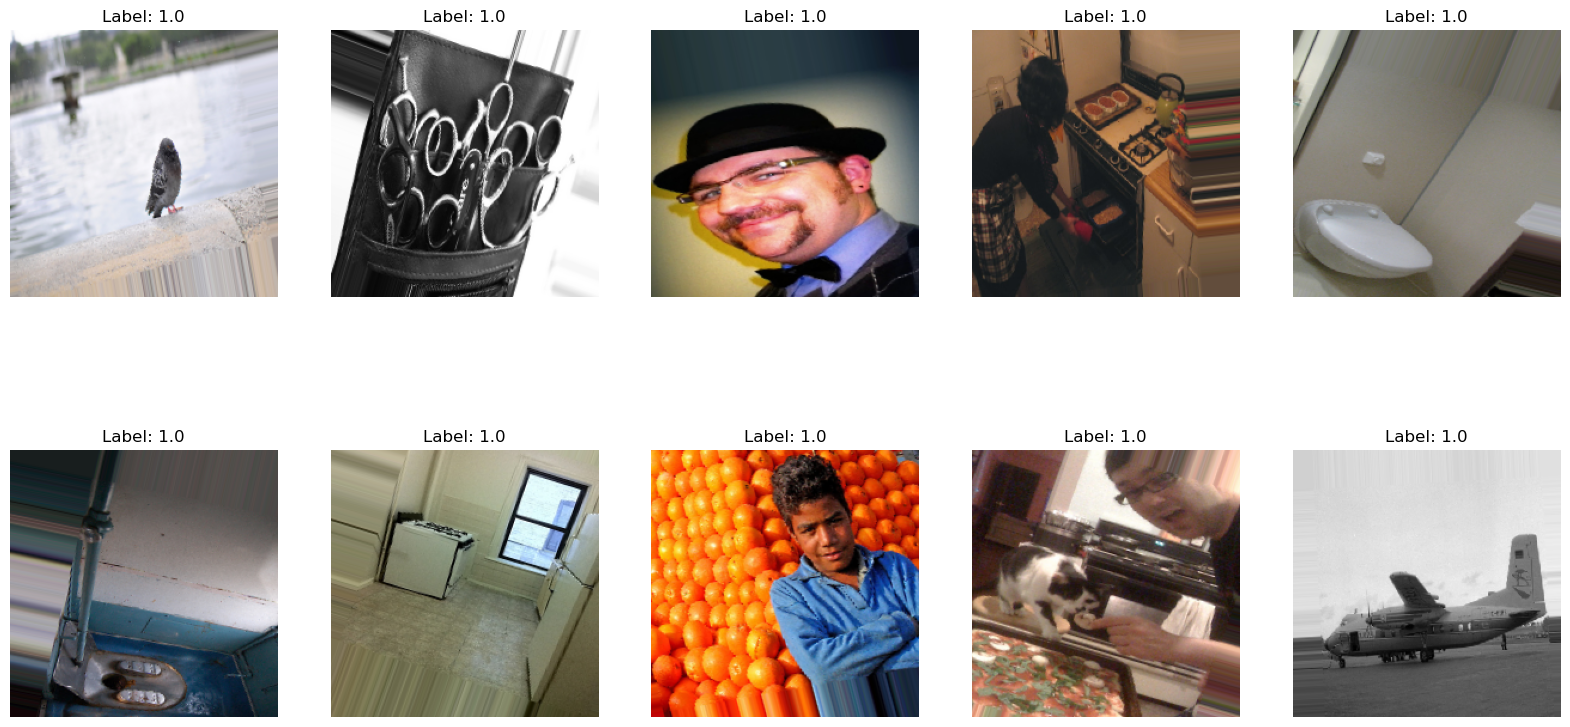

In [31]:
import matplotlib.pyplot as plt

# Extraire un batch d'images et de labels du générateur d'entraînement
images, labels = next(train_generator)

# Visualiser les premières 10 images et leurs labels
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()


In [35]:
# Évaluation du modèle sur l'ensemble de validation
loss, accuracy = model.evaluate(val_generator, steps=len(photos_val_gen) + len(others_val_gen))
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")


260/260 [==============================] - 207s 797ms/step - loss: 0.3950 - accuracy: 0.8277
Loss: 0.3950
Accuracy: 82.77%


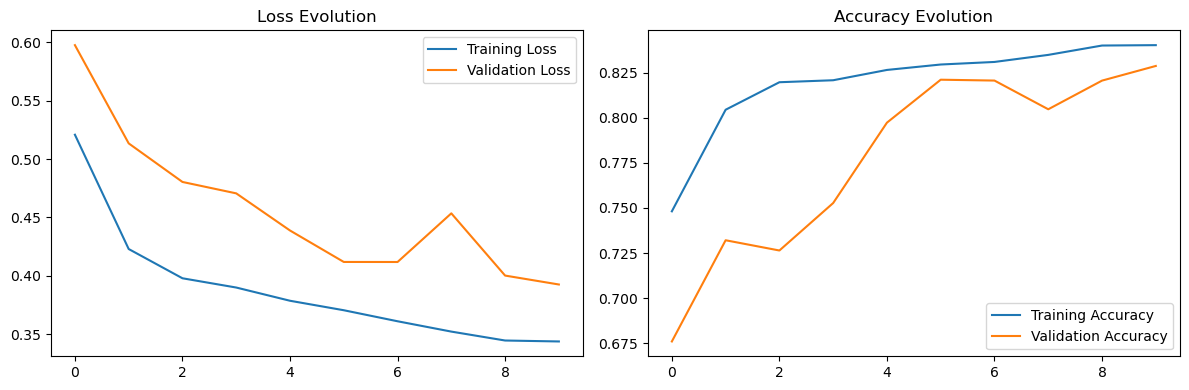

In [40]:
import matplotlib.pyplot as plt

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()


In [49]:
# Prédiction sur une nouvelle image
from tensorflow.keras.preprocessing import image

img_path = 'OIP.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = model.predict(img_array)
predicted_class = (prediction > 0.5).astype("int32")  # 1 pour "Photo", 0 pour "Autres"

print(f"Predicted Class: {'Photo' if predicted_class[0][0] == 1 else 'Others'}")


1/1 [==============================] - 0s 50ms/step
Predicted Class: Others


In [50]:
model.save('photo_classifier_model.h5')

In [52]:
from tensorflow.keras.models import load_model
model = load_model('photo_classifier_model.h5')


In [53]:
img_path = 'OIP.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = model.predict(img_array)
predicted_class = (prediction > 0.7).astype("int32")  # 1 pour "Photo", 0 pour "Autres"

print(f"Predicted Class: {'Photo' if predicted_class[0][0] == 1 else 'Others'}")

1/1 [==============================] - 0s 65ms/step
Predicted Class: Others
